In [213]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from tqdm import tqdm
import datetime
import random

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.applications import xception
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler



### load and process the data

In [2]:

def list_dir(directory):
    """
    get all images and labels in directory/label/*.jpg
    """
    # sort the labels to make sure training and testing get them in the same order 
    labels_dir = sorted(os.listdir(directory))
    
    files_and_labels = []
    # read files in each label folder
    for label in labels_dir:
        if label not in '.DS_Store':
            for f in os.listdir(os.path.join(directory, label)):
                files_and_labels.append((os.path.join(directory, label, f), label))

    filenames, labels = zip(*files_and_labels)
    filenames = list(filenames)
    labels = list(labels)
    # breeds names
    unique_labels = list(set(labels))
    
    # a dictioanry that saves the breeds names and corresbonding labels
    label_to_int = {}
    for i, label in enumerate(labels_dir):
        label_to_int[label] = i
    # use the dictionary to convert breeds name labels to integer labels
    labels = [label_to_int[l] for l in labels]
    
    return filenames, labels



# read the image labels in the order they are processed in the preprocessing.ipynb

file_train, label_train = list_dir('./train')
file_test, label_test = list_dir('./test')


# breeds name and integer label dictionary 

labels = sorted(os.listdir('./train'))
labels = list(labels)
name_dict = {}
for i, label in enumerate(labels):
    name_dict[label] = i
    


In [10]:

def path_to_tensor(img_path):
    """
    read image data to the four dimensional tensor format required by keras 
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size = (INPUT_SIZE, INPUT_SIZE))
    # convert PIL.Image.Image type to 3D tensor with shape (INPUT_SIZE, INPUT_SIZE, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, INPUT_SIZE, INPUT_SIZE, 3) and return 4D tensor
    x = np.expand_dims(x, axis = 0)
 
    return x


def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    
    return np.vstack(list_of_tensors)


INPUT_SIZE = 299
NUM_CLASSES = 120 

# image to tensor
x_train = paths_to_tensor(file_train).astype('float32')/255
x_test = paths_to_tensor(file_test).astype('float32')/255


# one hot encoded label creation 

y_train = pd.get_dummies(label_train)
y_train = np.asarray(y_train)

y_test = pd.get_dummies(label_test)
y_test = np.asarray(y_test)

print (y_train.shape)
print (y_test.shape)



100%|██████████| 2045/2045 [00:09<00:00, 205.11it/s]


(8177, 120)
(2045, 120)


76


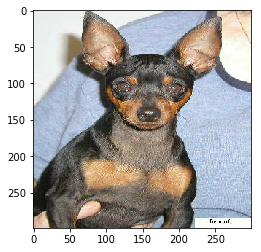

In [17]:
img_idx = 5104
print (label_train[img_idx])
plt.imshow(x_train[img_idx])


### data augmentation and training on Floyhub

In [18]:

train_gen = ImageDataGenerator(rotation_range = 45, 
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.25,
                               horizontal_flip = True,
                               fill_mode ='nearest')

test_gen = ImageDataGenerator()


In [37]:

# create the base pre-trained model
base_model = xception.Xception(weights = 'imagenet', include_top = False)

# add global average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# add fully connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
# classification layer
predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

# model
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [40]:

lr = 0.01
# learning rate decay with number of epochs 
def scheduler(epoch):
    return lr * 0.9 ** epoch

lr_scheduler = LearningRateScheduler(scheduler)

# checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only = True,
                                   save_weights_only = True)


# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr = 0.01, rho = 0.9)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
              metrics = ["accuracy"])



In [ ]:
# EPOCHS = 50
# BATCH_SIZE = 16

# # train the model on the new data for a few epochs
# history = model.fit_generator(train_gen.flow(x_train, y_train, batch_size = BATCH_SIZE),
#                               steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
#                               epochs = EPOCHS, 
#                               callbacks = [early_stopping, model_checkpoint],
#                               validation_data = test_gen.flow(x_test, y_test, batch_size = BATCH_SIZE),
#                               shuffle = True,
#                               validation_steps = y_test.shape[0] // BATCH_SIZE)



### inspection 

In [105]:
# training above is done on FloydHub
# load the trained model - lr_scheduler_dog_breed.h5

model.load_weights('./models/lr_scheduler_dog_breed.h5')

# prediciton on testing data 
model_output = model.predict(x_test)


In [221]:
# use the model on testing data and visualize some wrongly classified images 

# predcited label 
pred = np.argmax(model_output, axis = 1)

# prediction probabilities 
prob = np.max(model_output, axis = 1)

# prediction accuracy
truth = np.argmax(y_test, axis = 1)

print ('prediction accuracy: ', sum(pred == truth)/ truth.shape[0])


prediction accuracy:  0.7970660146699267


In [218]:
# wrong label index
error = (pred - truth != 0)

# find some wrongly classified images 
pred_error = pred[error]
prob_error = prob[error]
truth_error = truth[error]
image_error = np.array(file_test)[error]

# indices of images with wrong labels
top_index = random.sample(list(np.argsort(- np.array(prob_error))), 10)
top_index

[397, 283, 23, 199, 117, 322, 64, 320, 260, 167]

In [86]:
# name dict correction for breed names

# name_dict.pop('.DS_Store')

# keys = list(name_dict.keys())
# for i in range(len(keys)):
#     name_dict[keys[i]] = name_dict[keys[i]] -1 


In [219]:
# for these ten images

pred_label = pred_error[top_index]
pred_prob = prob_error[top_index]

pred_breed = []
for i in pred_label:
    pred_breed.append(list(name_dict.keys())[list(name_dict.values()).index(i)])


true_label = truth_error[top_index]

true_breed = []
for j in true_label:
    true_breed.append(list(name_dict.keys())[list(name_dict.values()).index(j)])



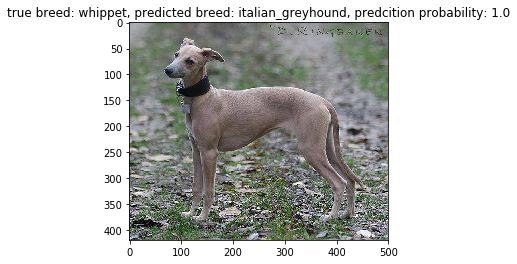

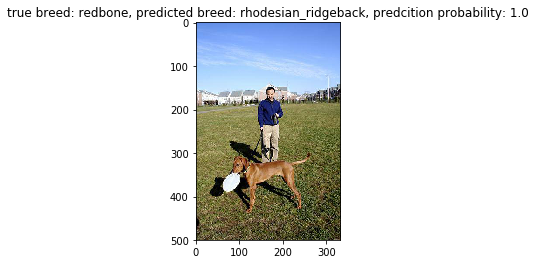

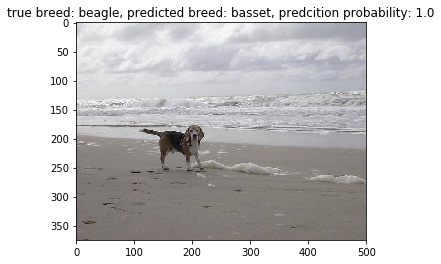

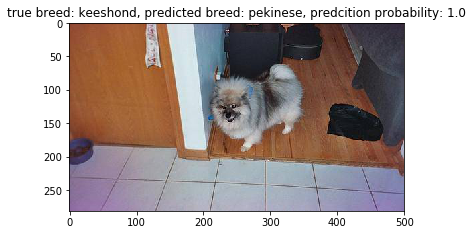

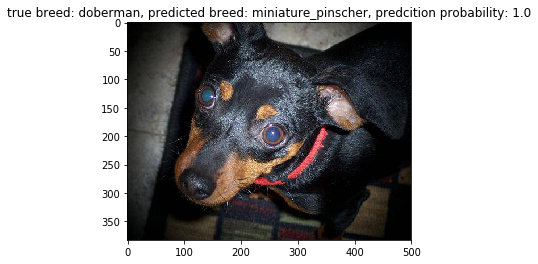

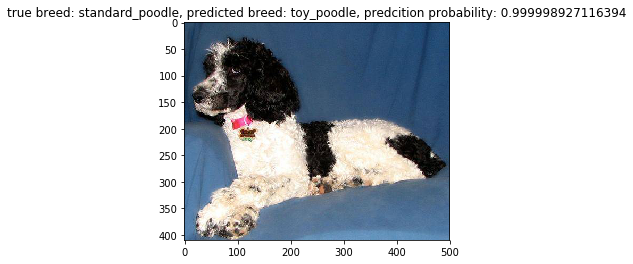

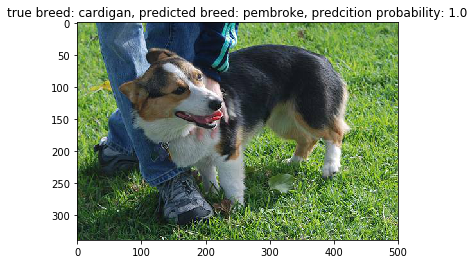

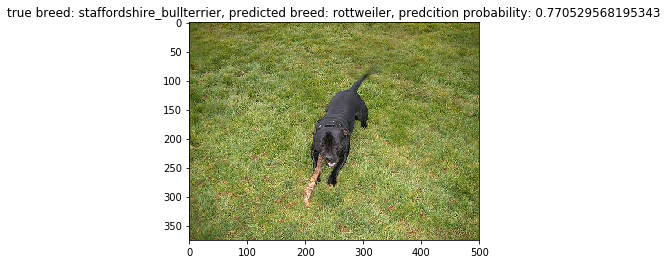

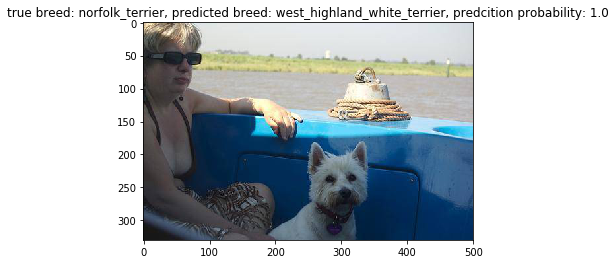

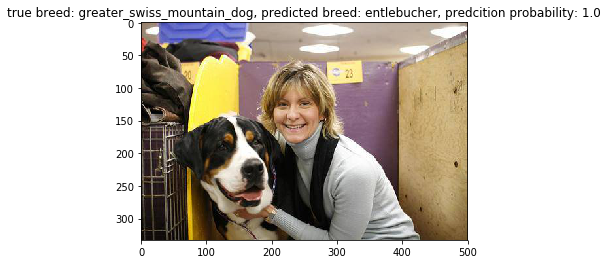

In [220]:
# show these images with their correct breeds and prediction probabilities

for i in range(len(top_index)):
    img = image.load_img(image_error[top_index][i])
    
    plt.figure()
    plt.imshow(img)
    plt.title('true breed: {}, predicted breed: {}, predcition probability: {}'.format(true_breed[i], pred_breed[i], pred_prob[i]))
 


In [227]:
# testing data label distribution 
v, c = np.unique(label_test, return_counts = True)
value = v[np.argsort(-c)]
count = c[np.argsort(-c)]
# np.asarray((value, count)).T

# testing data predicted label distribution
v, c = np.unique(pred, return_counts = True)
pred_value = v[np.argsort(-c)]
pred_count = c[np.argsort(-c)]
# np.asarray((pred_value, pred_count)).T


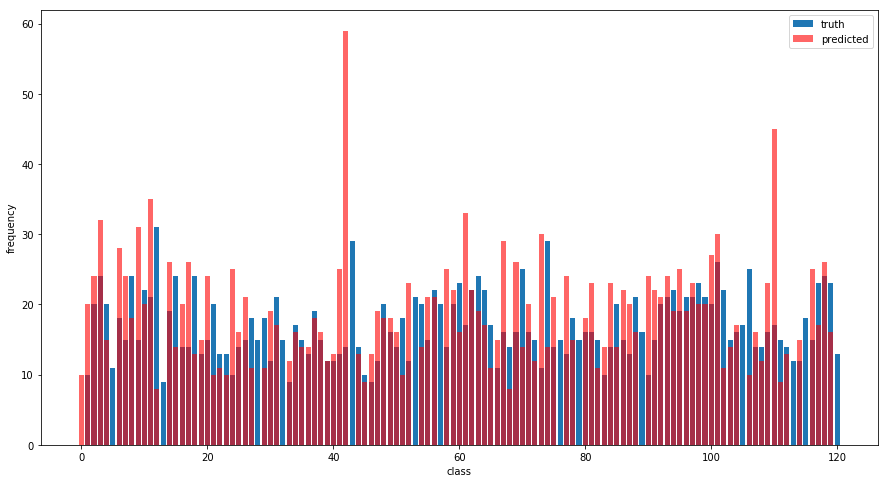

In [253]:
plt.figure(figsize = (15, 8))
plt.bar(value, count, label = 'truth')
plt.bar(pred_value, pred_count, color = 'red', alpha = 0.6, label = 'predicted')
plt.xlabel('class')
plt.ylabel('frequency')
plt.legend()


In [242]:
# most and least frequently predicted labels & their frequencies in the training data 

# pred_value = v[np.argsort(-c)]
# pred_count = c[np.argsort(-c)]

# most frequent labels and their frequency 
print (pred_value[: 3])
print (pred_count[: 3])
most_label = []
for i in range(len(pred_value[: 3])):
    most_label.append(list(name_dict.keys())[list(name_dict.values()).index(pred_value[: 3][i])])

# least frequent labels and their frequency 
print (pred_value[-3: ])
print (pred_count[-3: ])

least_label = []
for i in range(len(pred_value[-3: ])):
    least_label.append(list(name_dict.keys())[list(name_dict.values()).index(pred_value[-3: ][i])])


[ 42 110  11]
[59 45 35]
[45 12 68]
[9 8 8]


In [301]:
most_label, least_label

(['entlebucher', 'toy_poodle', 'bernese_mountain_dog'],
 ['french_bulldog', 'black-and-tan_coonhound', 'lakeland_terrier'])

#### not all labels are predicted 

In [302]:
train_ture_label = np.asarray(label_train) - 1

print('number of labels predicted on testing data:', len(np.unique(pred)))
print('number of labels in training data:', len(np.unique(train_ture_label)))
print('number of labels in testing data:', len(np.unique(truth)))

zero = [i for i in np.unique(train_ture_label) if i not in pred_value]

zero_label = []
for i in range(len(zero)):
    zero_label.append(list(name_dict.keys())[list(name_dict.values()).index(zero[i])])


number of labels predicted on testing data: 107
number of labels in training data: 120
number of labels in testing data: 120


In [303]:
# the following labels are not predicted in testing data 
zero_label


['appenzeller',
 'blenheim_spaniel',
 'chesapeake_bay_retriever',
 'cocker_spaniel',
 'eskimo_dog',
 'greater_swiss_mountain_dog',
 'irish_terrier',
 'miniature_poodle',
 'norfolk_terrier',
 'redbone',
 'standard_poodle',
 'walker_hound',
 'welsh_springer_spaniel']

In [259]:

# training data label distribution
v, c = np.unique(train_ture_label, return_counts = True)
train_value = v[np.argsort(-c)]
train_count = c[np.argsort(-c)]

# frequency of frequently predicted labels in training data 
most = []
for i in pred_value[: 3]:
    most.append(train_count[np.where(train_value == i)])
    
least = []
for i in pred_value[-3: ]:
    least.append(train_count[np.where(train_value == i)])


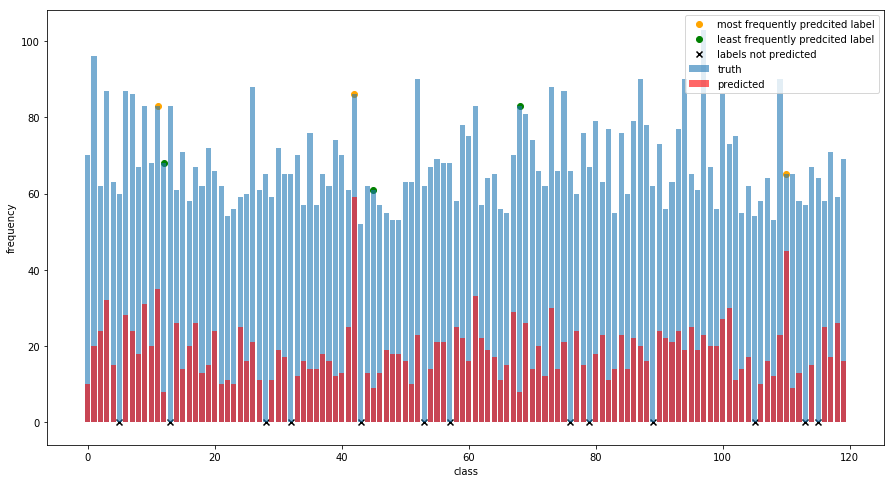

In [306]:
plt.figure(figsize = (15, 8))
plt.bar(train_value, train_count, alpha = 0.6, label = 'truth')
plt.bar(pred_value, pred_count, color = 'red', alpha = 0.6, label = 'predicted')
plt.scatter(pred_value[: 3], most, color = 'orange', label = 'most frequently predcited label')
plt.scatter(pred_value[-3: ], least, color = 'green', label = 'least frequently predcited label')
plt.scatter(zero, np.zeros(len(zero)), color = 'black', label = 'labels not predicted', marker = 'x')
plt.xlabel('class')
plt.ylabel('frequency')
plt.legend()


In [328]:
# for images with those labels that are not predicted, lables assigned are ...

# gather all testing data that belong to the classes that are not predicted 

for j in range(len(zero)):
    print('true breed:',zero_label[j], '\n')
    wrong = np.unique(pred[truth == zero[j]])
    print('predicted breeds:')
    for i in range(len(wrong)):
        print (list(name_dict.keys())[list(name_dict.values()).index(wrong[i])])
    print('==', '\n')


true breed: appenzeller 

predicted breeds:
bernese_mountain_dog
entlebucher
kelpie
miniature_pinscher
rottweiler
== 

true breed: blenheim_spaniel 

predicted breeds:
brittany_spaniel
japanese_spaniel
papillon
sussex_spaniel
== 

true breed: chesapeake_bay_retriever 

predicted breeds:
curly-coated_retriever
golden_retriever
irish_setter
labrador_retriever
leonberg
rhodesian_ridgeback
vizsla
== 

true breed: cocker_spaniel 

predicted breeds:
clumber
english_springer
golden_retriever
sussex_spaniel
toy_poodle
== 

true breed: eskimo_dog 

predicted breeds:
malamute
siberian_husky
== 

true breed: greater_swiss_mountain_dog 

predicted breeds:
bernese_mountain_dog
entlebucher
== 

true breed: irish_terrier 

predicted breeds:
airedale
australian_terrier
border_terrier
lakeland_terrier
miniature_schnauzer
norwich_terrier
== 

true breed: miniature_poodle 

predicted breeds:
dandie_dinmont
norwich_terrier
tibetan_terrier
toy_poodle
== 

true breed: norfolk_terrier 

predicted breeds:
aus

In [336]:
# fine tune more layers 

# the first 116 layers and unfreeze the rest:
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True



# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9),
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

# model.summary()

In [ ]:

# train the model for a few epochs
history = model.fit_generator(train_gen.flow(x_train, y_train, batch_size = BATCH_SIZE),
                           steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
                           initial_epoch = 45,
                           epochs = 46,
                           validation_data = test_gen.flow(x_test, y_test, batch_size = BATCH_SIZE),
                           validation_steps = x_test.shape[0] // BATCH_SIZE)


bst_val_acc = max(history.history['val_acc'])
print("Best val acc: {:.1%}".format(bst_val_acc))
# Save model
model.save_weights("{}_{}_fine-tuned".format(STAMP, bst_val_acc))

